## Process result from Curtis

In this notebook we start from the result provided by Curtis, then do label math to try and join the split pedals. 

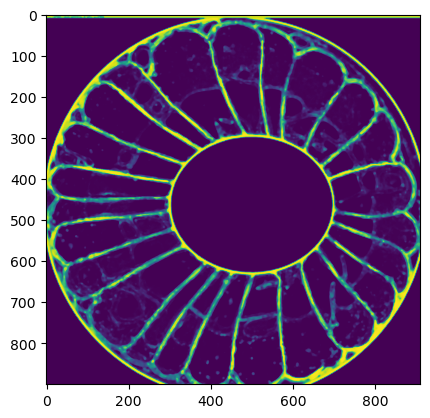

In [128]:
from pathlib import Path
from skimage.io import imread, imsave
from matplotlib import pyplot as plt
from skimage.filters import median 
from skimage.morphology import disk

tnia_images_path = Path(r'D:/images')
parent_path=Path(tnia_images_path / r'D:\images\tnia-python-images\imagesc\2024_03_08_flower_like')
work_path = parent_path / 'work'

if not work_path.exists():
    work_path.mkdir(parents=True)

# Load the image
image = imread(parent_path / 'smoothed-small.png')
plt.imshow(image)

image = image[50:950,20:930,0]

# Create a disk-shaped structuring element with a radius of 3 pixels
selem = disk(3)

# Apply the median filter
image = median(image, selem)

plt.imshow(image)

imsave(work_path / 'smoothed-small-crop.tif', image)

C:\Users\bnort\AppData\Local\Temp\ipykernel_20052\2827988026.py:9: UserWarning: D:\images\tnia-python-images\imagesc\2024_03_08_flower_like\work\threshold_outlines_li.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(work_path / 'threshold_outlines_li.tif', binary)
C:\Users\bnort\AppData\Local\Temp\ipykernel_20052\2827988026.py:25: UserWarning: D:\images\tnia-python-images\imagesc\2024_03_08_flower_like\work\outlines_filtered_area_lt_200.tif is a low contrast image
  imsave(work_path / 'outlines_filtered_area_lt_200.tif', labeled_filtered)


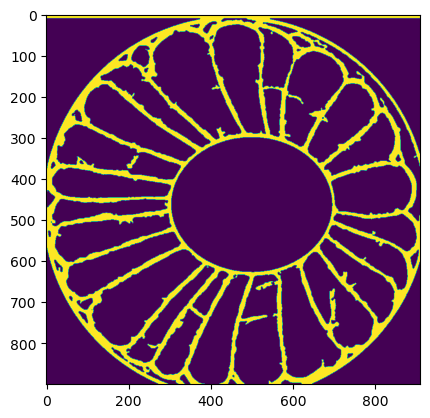

In [129]:
from skimage.filters import threshold_otsu, threshold_li
from skimage.measure import label, regionprops
import numpy as np

# Apply threshold
thresh = threshold_li(image)
binary = image > thresh

imsave(work_path / 'threshold_outlines_li.tif', binary)

labeled = label(binary)

min_area = 200 

object_list=regionprops(labeled)
labeled_filtered=np.zeros_like(labeled)

for obj in object_list:
    
    if obj.area > min_area:
        labeled_filtered[labeled==obj.label]=1

plt.imshow(labeled_filtered)

imsave(work_path / 'outlines_filtered_area_lt_200.tif', labeled_filtered)

C:\Users\bnort\AppData\Local\Temp\ipykernel_20052\1189635463.py:7: UserWarning: D:\images\tnia-python-images\imagesc\2024_03_08_flower_like\work\petals_thresholded.tif is a low contrast image
  imsave(work_path / 'petals_thresholded.tif', thresholded)


(463.04345066301687, 500.09838634492746)
angle SAME! 2.9001459495128667 2.8187520878682233
angle SAME! -0.4293958337546641 -0.3435443470937646
25


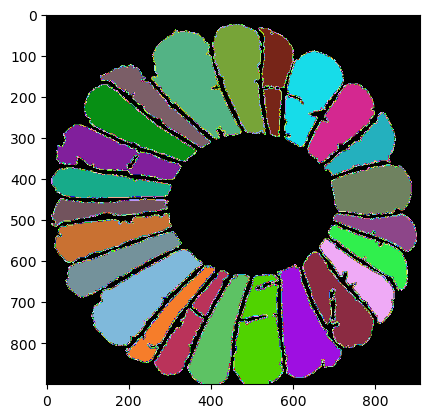

In [130]:
from skimage.measure import label, regionprops
from matplotlib.colors import ListedColormap
import numpy as np

thresholded = 1-labeled_filtered 

imsave(work_path / 'petals_thresholded.tif', thresholded)

# Create a random colormap
random_colors = np.random.rand(256,3)
random_colors[0] = [0,0,0]
random_cmap = ListedColormap(random_colors)

labeled = label(thresholded)

max_area = 30000

object_list=regionprops(labeled)
labeled_filtered_2=labeled.copy()

for obj in object_list:
    #if obj.area > max_area:
    if obj.eccentricity < 0.7 and obj.area > max_area:
        center = obj.centroid
        print(center)
        labeled_filtered_2[labeled==obj.label]=0

imsave(work_path / 'petals_filtered_area_gt_200_and_eccentricity_lt_0.7.tif', labeled_filtered_2.astype(np.uint8))

for obj in object_list:

    distance_from_center = np.sqrt((obj.centroid[0]-center[0])**2 + (obj.centroid[1]-center[1])**2)
    #if obj.area > max_area:
    if distance_from_center > 400:
        labeled_filtered_2[labeled==obj.label]=0
    if obj.bbox[3] > image.shape[1]-1:
        labeled_filtered_2[labeled==obj.label]=0
    if obj.area < 200:
        labeled_filtered_2[labeled==obj.label]=0
def compute_angle(x,y):
    return np.arctan2(y-center[0],x-center[1])


object_list=regionprops(labeled_filtered_2)

for obj in object_list:
    angle = compute_angle(obj.centroid[0],obj.centroid[1])
    for obj2 in object_list:
        angle2 = compute_angle(obj2.centroid[0],obj2.centroid[1])

        if abs(angle-angle2) < 0.1 and obj.label != obj2.label and obj.area > obj2.area:
            print('angle SAME!', angle, angle2)
            labeled_filtered_2[labeled==obj2.label]=obj.label
            break
       
        #print(100*angle)
imsave(work_path / 'petals_filtered_merge_angle.tif', labeled_filtered_2.astype(np.uint8))
num_unique = len(np.unique(labeled_filtered_2))
print(num_unique)

plt.imshow(labeled_filtered_2, cmap=random_cmap)

In [131]:
import napari as Viewer
viewer = Viewer.Viewer()
viewer.add_image(image, name='image')
viewer.add_labels(labeled_filtered_2, name='labeled_filtered_2')

<Labels layer 'labeled_filtered_2' at 0x287cb9187f0>

In [118]:
from skimage.io import imsave

# get napari scrren shot and save
ss=viewer.screenshot()
imsave(parent_path / 'labeled_filtered_2.png', ss)